# Overview

In this notebook, we explore hits for a few motifs/cell types of interest, to visualize
their nucleotide composition and contribution scores across all hits/predictive instances. The
basic structure is that for each motif/cell type, we call a wrapper which will:

1. trim the CWM for that motif
2. extract one-hot-encoded DNA sequence in the regions corresponding to hits for that motif
3. extract base-resolution contribution scores in those same regions

Then, we use the one-hot-encoded sequence & contribution scores to visualize hits.
We focus on a few motifs of interest. The purpose of visualizing the nucleotide composition is
to convince ourselves that the calling of the motif instances actually resemble the motif.

_Run on sherlock._

# Set up

In [1]:
%load_ext autoreload
%autoreload 2

# deal with matplotlib plots
%matplotlib inline

# display all outputs in a cell
get_ipython().ast_node_interactivity = 'all'

from IPython.display import display

In [ ]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logomaker
import chrombpnet
import pyfaidx
import h5py
import pyBigWig

# get custom helper functions
sys.path.append("..")
import chrombpnet_utils as cutils

In [ ]:
with open("../../ROOT_DIR.txt", 'r') as f:
    proj_dir = f.readline().strip()

with open("../../AK_PROJ_DIR.txt", 'r') as f:
    kundaje_dir = f.readline().strip()

In [17]:
# input paths
chrombpnet_dir = os.path.join(proj_dir, "output/03-chrombpnet")
contribs_dir = os.path.join(chrombpnet_dir, "01-models/contribs/bias_Heart_c0_thresh0.4")
hits_dir = os.path.join(chrombpnet_dir, "02-compendium/hits_unified_motifs/reconciled_per_celltype_peaks")
phastcons_path = os.path.join(kundaje_dir, "refs/hg38/phastCons/hg38.phastCons100way.bw")
phylop_path = os.path.join(kundaje_dir, "refs/hg38/phyloP/hg38.phyloP100way.bw")

# output paths
figout = os.path.join(proj_dir, "figures/03-chrombpnet/03-syntax/03")
os.makedirs(figout, exist_ok=True)

In [18]:
# load genome
genome_fa = os.path.join(kundaje_dir, "refs/hg38/chrombpnet/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")
genome = pyfaidx.Fasta(genome_fa)

In [19]:
# load compiled modisco object, containing merged motifs
compiled_modisco_h5_path = os.path.join(chrombpnet_dir, "02-compendium/modisco_compiled/modisco_compiled.h5")
modisco_obj = h5py.File(compiled_modisco_h5_path)

In [23]:
# load annotated motifs
motifs_compiled = pd.read_csv(os.path.join(chrombpnet_dir, "03-syntax/01/motifs_compiled_unique.tsv"), sep = "\t")
motifs_compiled[["idx_uniq", "motif_name", "pattern", "annotation", "category"]]

,idx_uniq,motif_name,pattern,annotation,category
0,0,0|AP-2,pos.Average_272__merged_pattern_1,AP-2,base
1,100,100|BZIP:ATF/CREB#2,pos.Average_280__merged_pattern_37,BZIP:ATF/CREB#2,base_with_flank
2,101,101|BZIP:ATF/CREB#3,pos.Average_306__merged_pattern_77,BZIP:ATF/CREB#3,base_with_flank
3,102,102|BZIP:ATF/CREB#4,pos.Average_116__merged_pattern_0,BZIP:ATF/CREB#4,base_with_flank
4,103,103|BZIP:ATF/CREB#5,pos.Average_85__merged_pattern_6,BZIP:ATF/CREB#5,base_with_flank
...,...,...,...,...,...
503,96,96|BHLH_ZEB/SNAI_ZEB/SNAI,neg.Average_12__merged_pattern_6,BHLH_ZEB/SNAI_ZEB/SNAI,heterocomposite
504,97,97|BHLH_p53,pos.Average_229__merged_pattern_4,BHLH_p53,heterocomposite
505,98,98|BHLHpartial,pos.Average_303__merged_pattern_13,BHLHpartial,partial
506,99,99|BZIP:ATF/CREB#1,pos.Average_280__merged_pattern_0,BZIP:ATF/CREB#1,base


In [25]:
# set params used for hits
finemo_param = "counts_v0.23_a0.8_all"
hit_counts = pd.read_csv(os.path.join(chrombpnet_dir, "03-syntax/01/hits_per_cluster_annotated.tsv"), sep = "\t")
hit_counts.head()

,Cluster,motif_name,pattern_class,n,Distal,Exonic,Intronic,Promoter,mean_distToTSS,median_distToTSS,...,median_ngene,median_nfrags,median_tss,median_frip,note,organ_color,compartment_color,pattern,annotation_broad,category
0,Adrenal_c0,392|NR:ESRRA/NR5A,pos_patterns,158975,52205.0,9379.0,84616.0,12775.0,20180.92,8859.0,...,3280.0,6784.0,9.832,0.290609,NR5A1+ CYP11A1/CYP11B1+; mostly PCW21; groups with 2 and 3 in cluster tree,#876941,#11A579,pos.Average_256__merged_pattern_0,NR,base
1,Adrenal_c0,456|ZEB/SNAI,neg_patterns,122904,31275.0,8002.0,48500.0,35127.0,11567.57,2944.0,...,3280.0,6784.0,9.832,0.290609,NR5A1+ CYP11A1/CYP11B1+; mostly PCW21; groups with 2 and 3 in cluster tree,#876941,#11A579,neg.Average_12__merged_pattern_0,ZEB/SNAI,base
2,Adrenal_c0,132|BZIP:FOSL/JUND#1,pos_patterns,52506,17353.0,2527.0,28584.0,4042.0,20839.47,9456.0,...,3280.0,6784.0,9.832,0.290609,NR5A1+ CYP11A1/CYP11B1+; mostly PCW21; groups with 2 and 3 in cluster tree,#876941,#11A579,pos.Average_287__merged_pattern_0,BZIP,base
3,Adrenal_c0,436|SP/KLF,pos_patterns,45828,6164.0,2238.0,9426.0,28000.0,3203.65,140.0,...,3280.0,6784.0,9.832,0.290609,NR5A1+ CYP11A1/CYP11B1+; mostly PCW21; groups with 2 and 3 in cluster tree,#876941,#11A579,pos.Average_212__merged_pattern_0,SP/KLF,base
4,Adrenal_c0,260|GATA#1,pos_patterns,33086,11270.0,1370.0,18616.0,1830.0,22932.57,10593.5,...,3280.0,6784.0,9.832,0.290609,NR5A1+ CYP11A1/CYP11B1+; mostly PCW21; groups with 2 and 3 in cluster tree,#876941,#11A579,pos.Average_248__merged_pattern_0,GATA,base


In [26]:
def get_motifs_compiled(index=None, motif_name=None):
    """
    Pull out the info associated with one merged motif, given the unique
    index or the annotated motif name in the form of '<idx>|<anno>#<num>'
    """

    assert index is not None or motif_name is not None, "must provide either index or motif name"

    if index is not None:
        return motifs_compiled[motifs_compiled["idx_uniq"] == index][
            ["idx", "idx_uniq", "motif_name", "pattern", "annotation", "annotation_broad", "category"]]
    elif motif_name is not None:
        return motifs_compiled[motifs_compiled["motif_name"] == motif_name][
            ["idx", "idx_uniq", "motif_name", "pattern_class", "pattern", "annotation", "annotation_broad", "category"]]

# Visualize hits

## ONECUT in Liver_c4

In [27]:
cluster = "Liver_c4"
motif = "403|ONECUT#1"
motif_info = get_motifs_compiled(motif_name = motif)
pattern = motif_info["pattern"].values[0]
idx = motif_info["idx_uniq"].values[0]
out_prefix = os.path.join(figout, f"{cluster}_{idx}")

/oak/stanford/groups/wjg/skim/projects/HDMA-public/figures/03-chrombpnet/03-syntax/03/Liver_c4_403


In [31]:
cwm, imp_start, imp_end, hits_df, ohe, contribs = cutils.modisco.extract_hit_data(
    modisco_obj = modisco_obj,
    contribs_bw = f"{contribs_dir}/{cluster}/average_shaps.counts.bw",
    conservation_bw = phylop_path,
    hits = f"{hits_dir}/{cluster}/{finemo_param}/hits_unique.reconciled.annotated.tsv.gz",
    genome = genome,
    pattern_name = pattern,
    motif_name = motif,
    revcomp_strand = "-",
    trim = False)

@ returning hits without trimming.
@ returning 6093 hits
@ reverse complementing hit one-hot-encodings and SHAPs


In [32]:
cwm.shape
ohe[0].shape

(30, 4)

(30, 4)

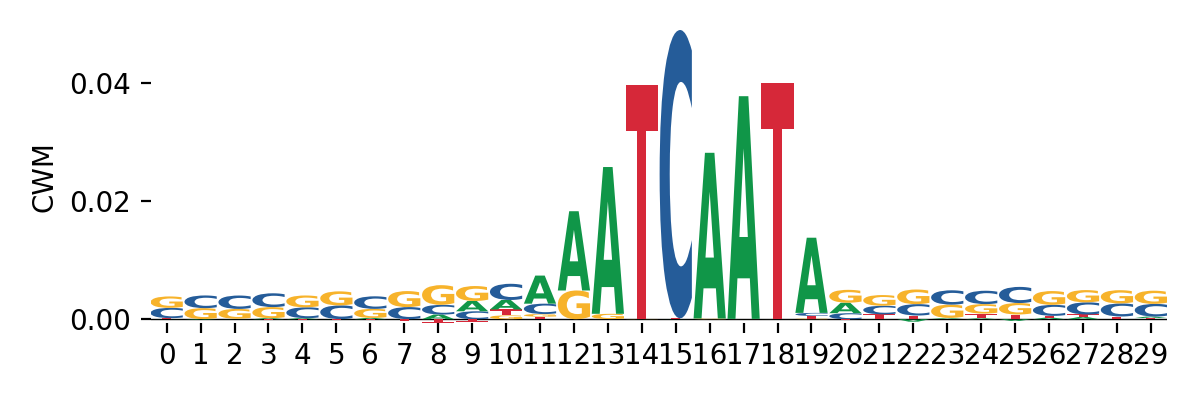

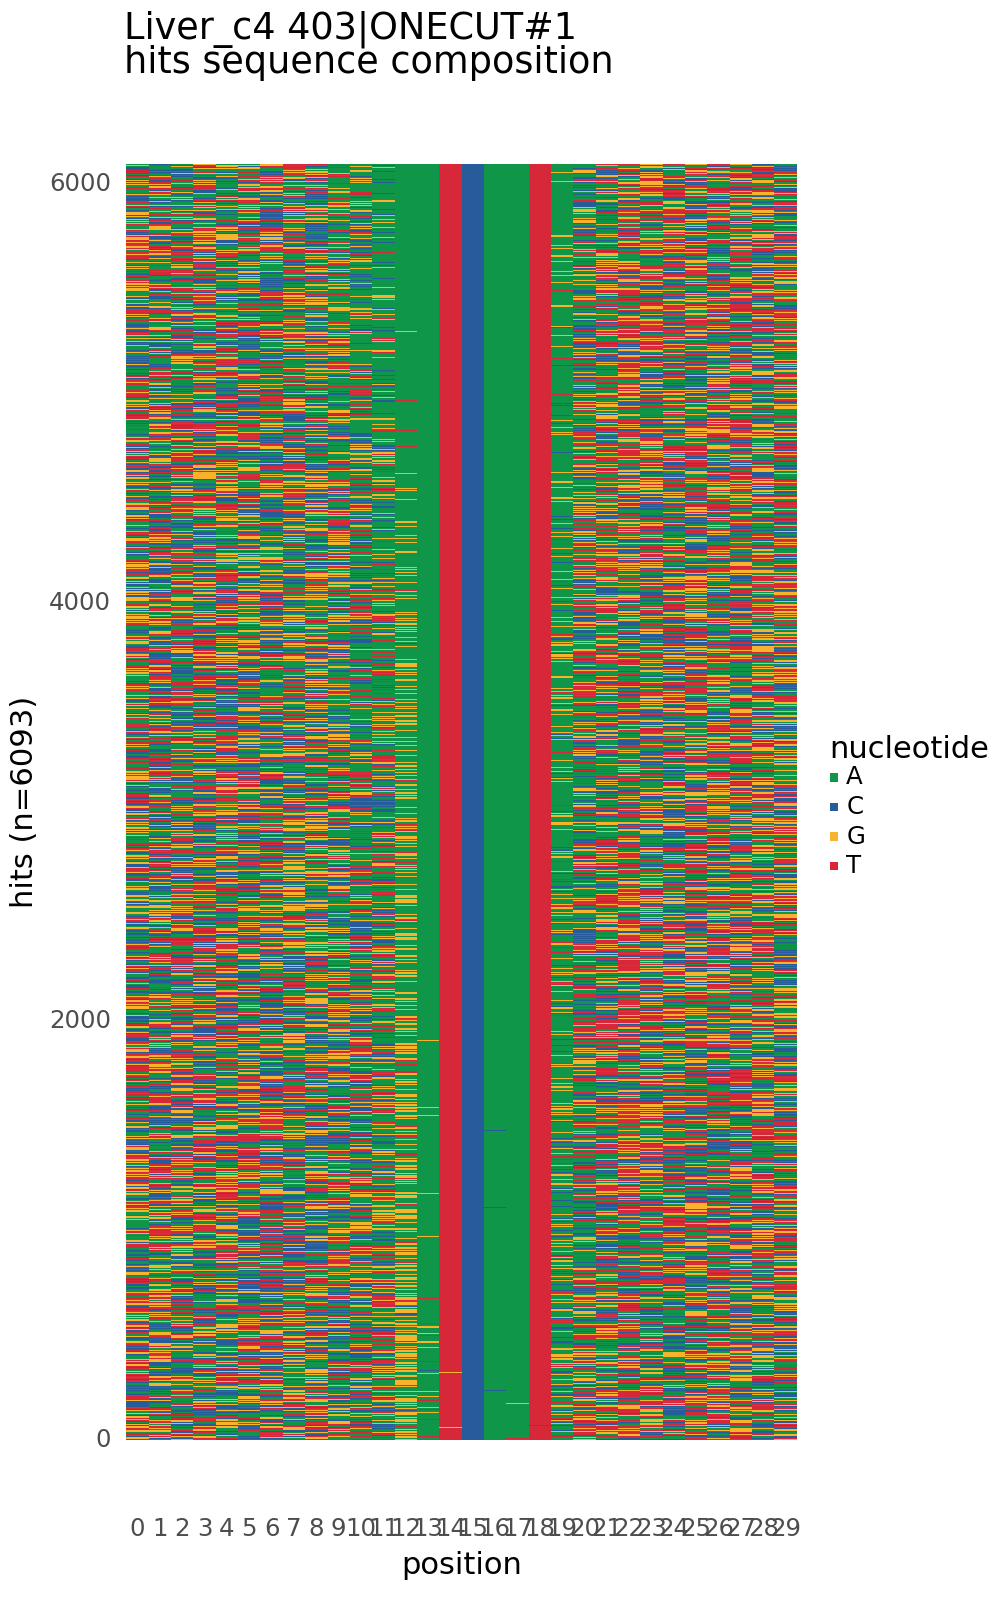

<Figure Size: (500 x 800)>

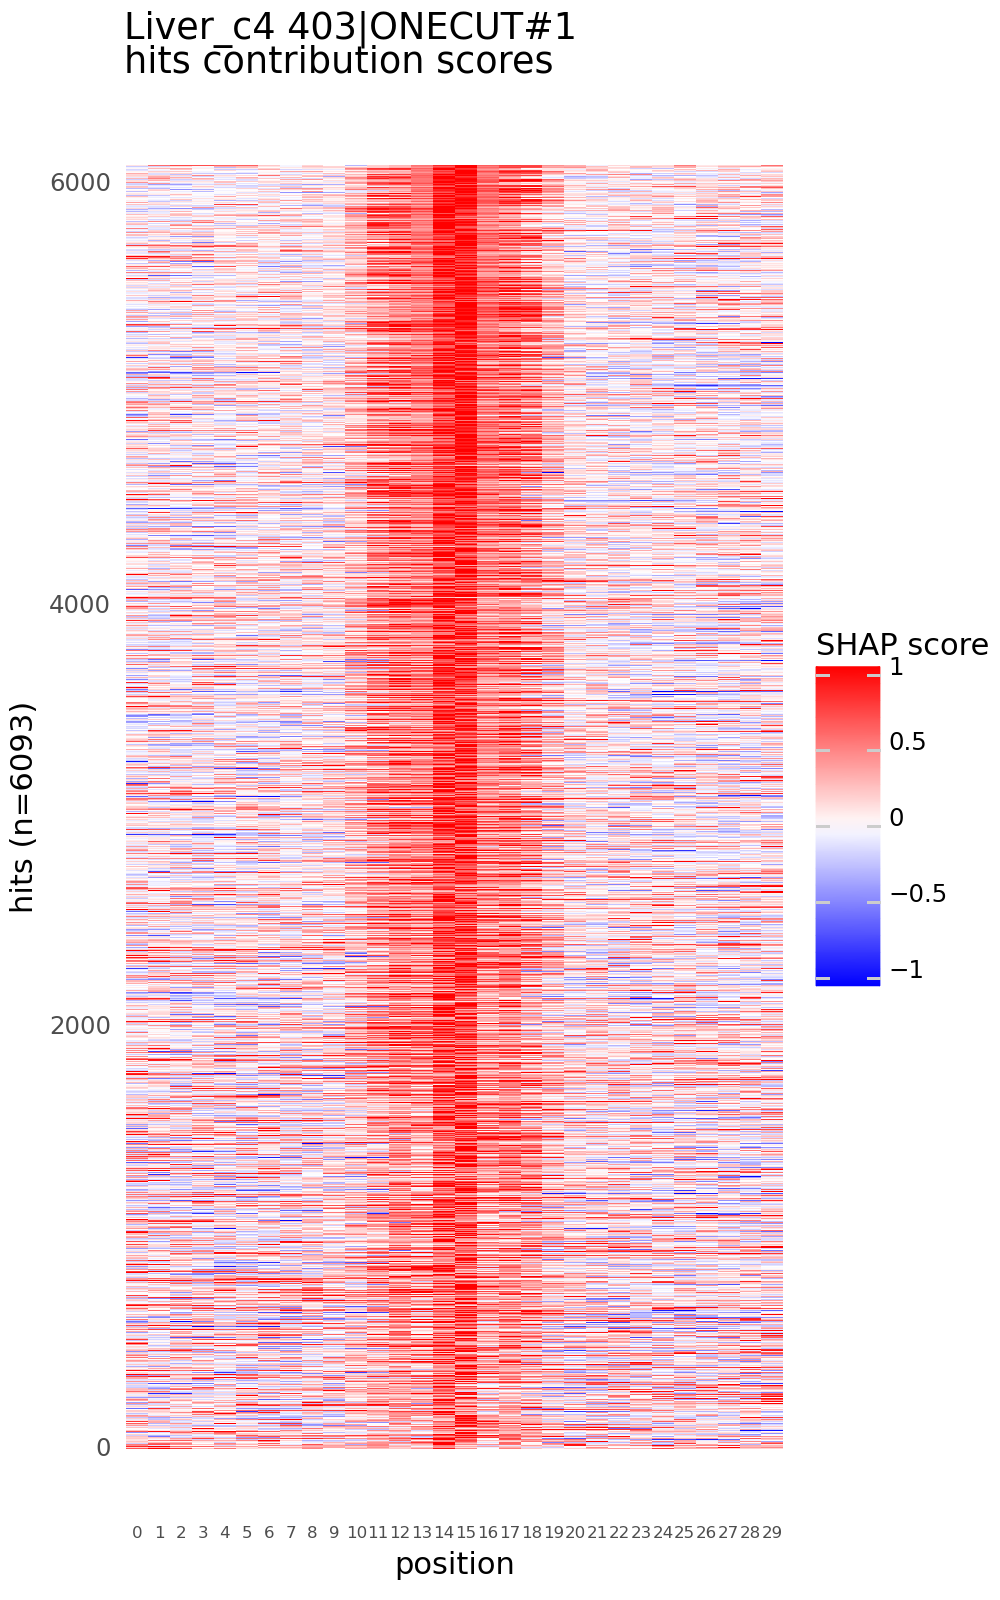

<Figure Size: (500 x 800)>

In [33]:
# order hits
hit_order = hits_df.sort_values(by='hit_correlation').index

# trimmed CWM
# cutils.plot.plot_logo(cwm[imp_start:imp_end].T)
cutils.plot.plot_logo(cwm.T)
plt.savefig(f"{out_prefix}_cwm.pdf", dpi=150);

# nuc composition heatmap
p1 = cutils.plot.hit_heatmap2(ohe, pattern_name=f"{cluster} {motif}", figsize=(5,8), hit_order = hit_order)
p1.save(filename=f"{out_prefix}_nuc_composition.pdf", width=5, height=8, units='in', dpi=1000, verbose=False);
p1;

# contribs heatmap
p2 = cutils.plot.hit_contrib_heatmap(contribs, pattern_name=f"{cluster} {motif}", figsize=(5,8), hit_order = hit_order, normalize=True);
p2.save(filename=f"{out_prefix}_contrib_scores.pdf", width=5, height=8, units='in', dpi=1000, verbose=False);
p2

## BHLH / HD motifs in Skin

In [34]:
# motif = "16|BHLH:ATOH/NEUROD_HD" # ---> worse
cluster = "Skin_c0"
motif = "71|BHLH_HD#2"
motif_info = get_motifs_compiled(motif_name = motif)
pattern = motif_info["pattern"].values[0]
idx = motif_info["idx_uniq"].values[0]
out_prefix = os.path.join(figout, f"{cluster}_{idx}")

In [36]:
cwm, imp_start, imp_end, hits_df, ohe, contribs = cutils.modisco.extract_hit_data(
    modisco_obj = modisco_obj,
    contribs_bw = f"{contribs_dir}/{cluster}/average_shaps.counts.bw",
    conservation_bw = phylop_path,
    hits = f"{hits_dir}/{cluster}/{finemo_param}/hits_unique.reconciled.annotated.tsv.gz",
    genome = genome,
    pattern_name = pattern,
    motif_name = motif,
    revcomp_strand = "-")

@ returning hits trimmed to width 24
@ returning 9021 hits
@ reverse complementing hit one-hot-encodings and SHAPs


In [37]:
cwm[imp_start:imp_end].shape
ohe[0].shape

(24, 4)

(24, 4)

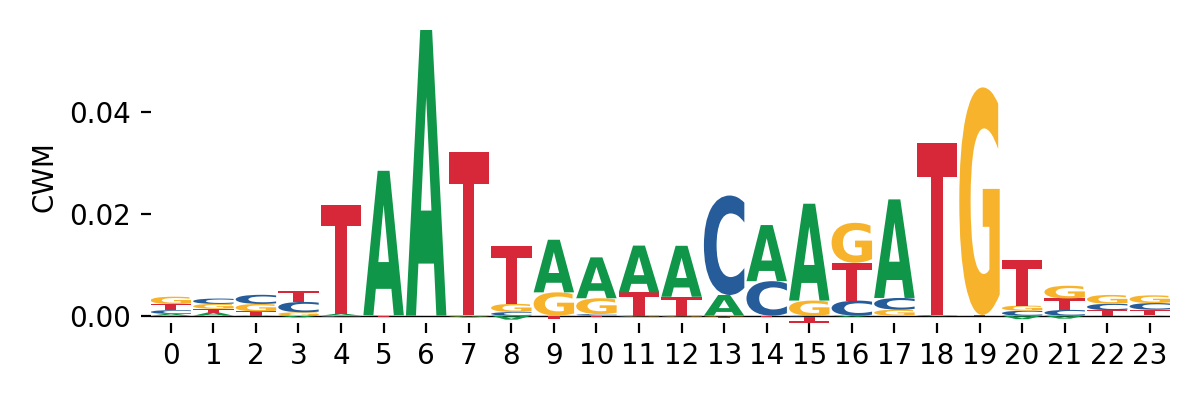

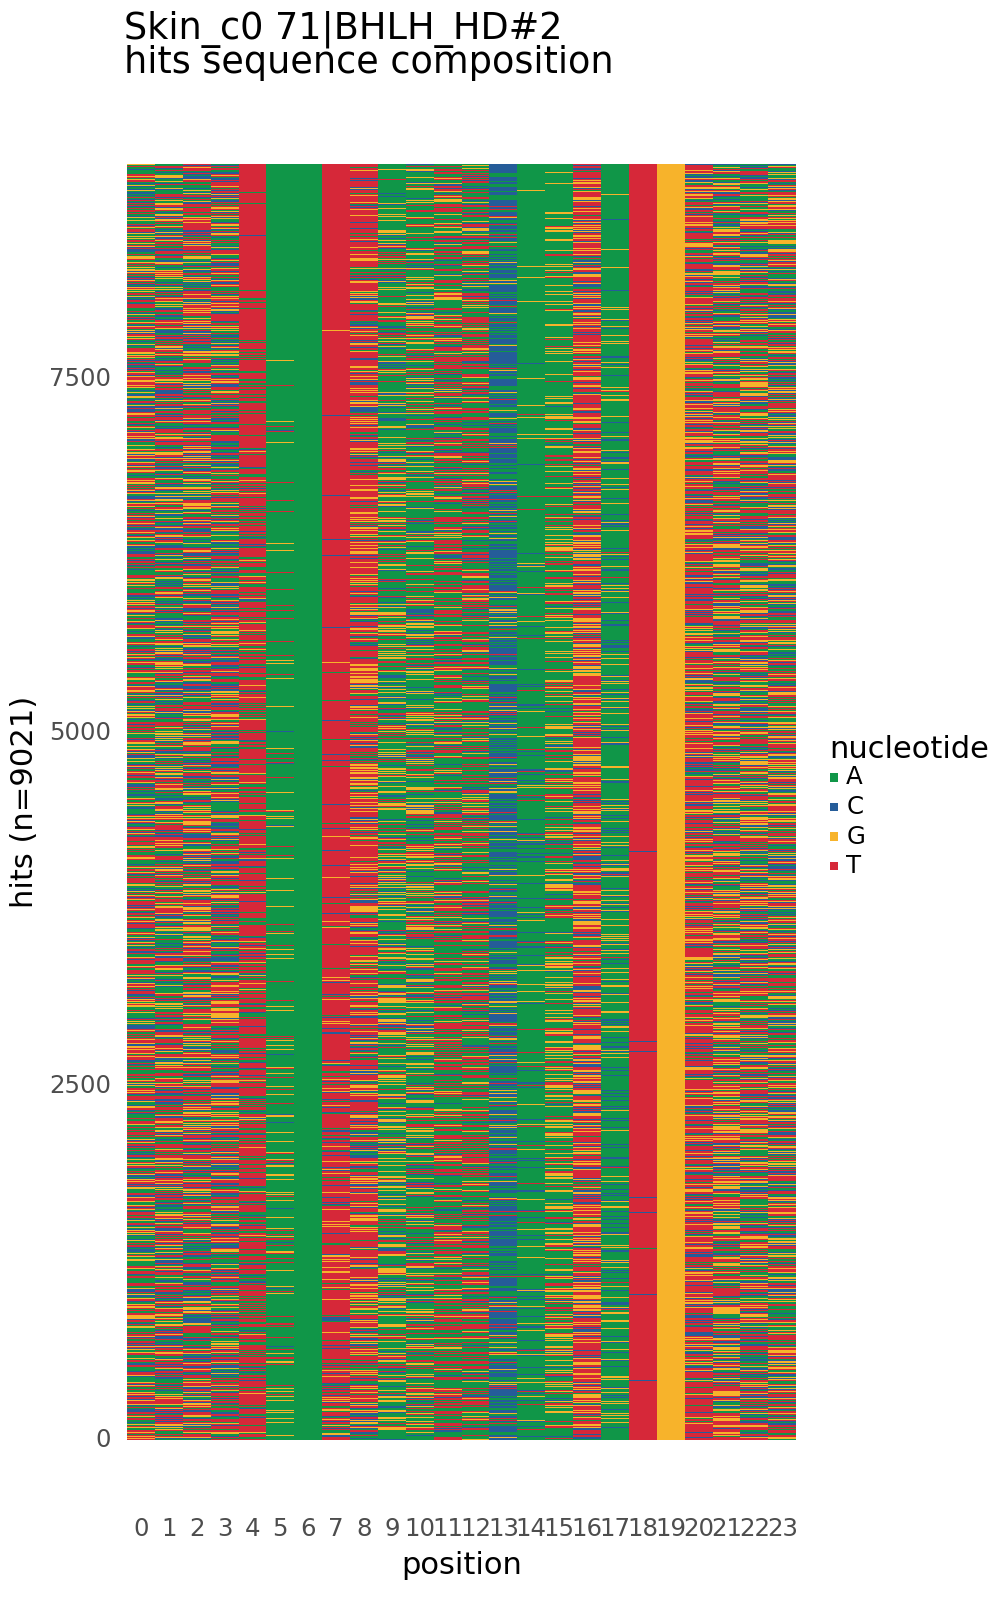

<Figure Size: (500 x 800)>

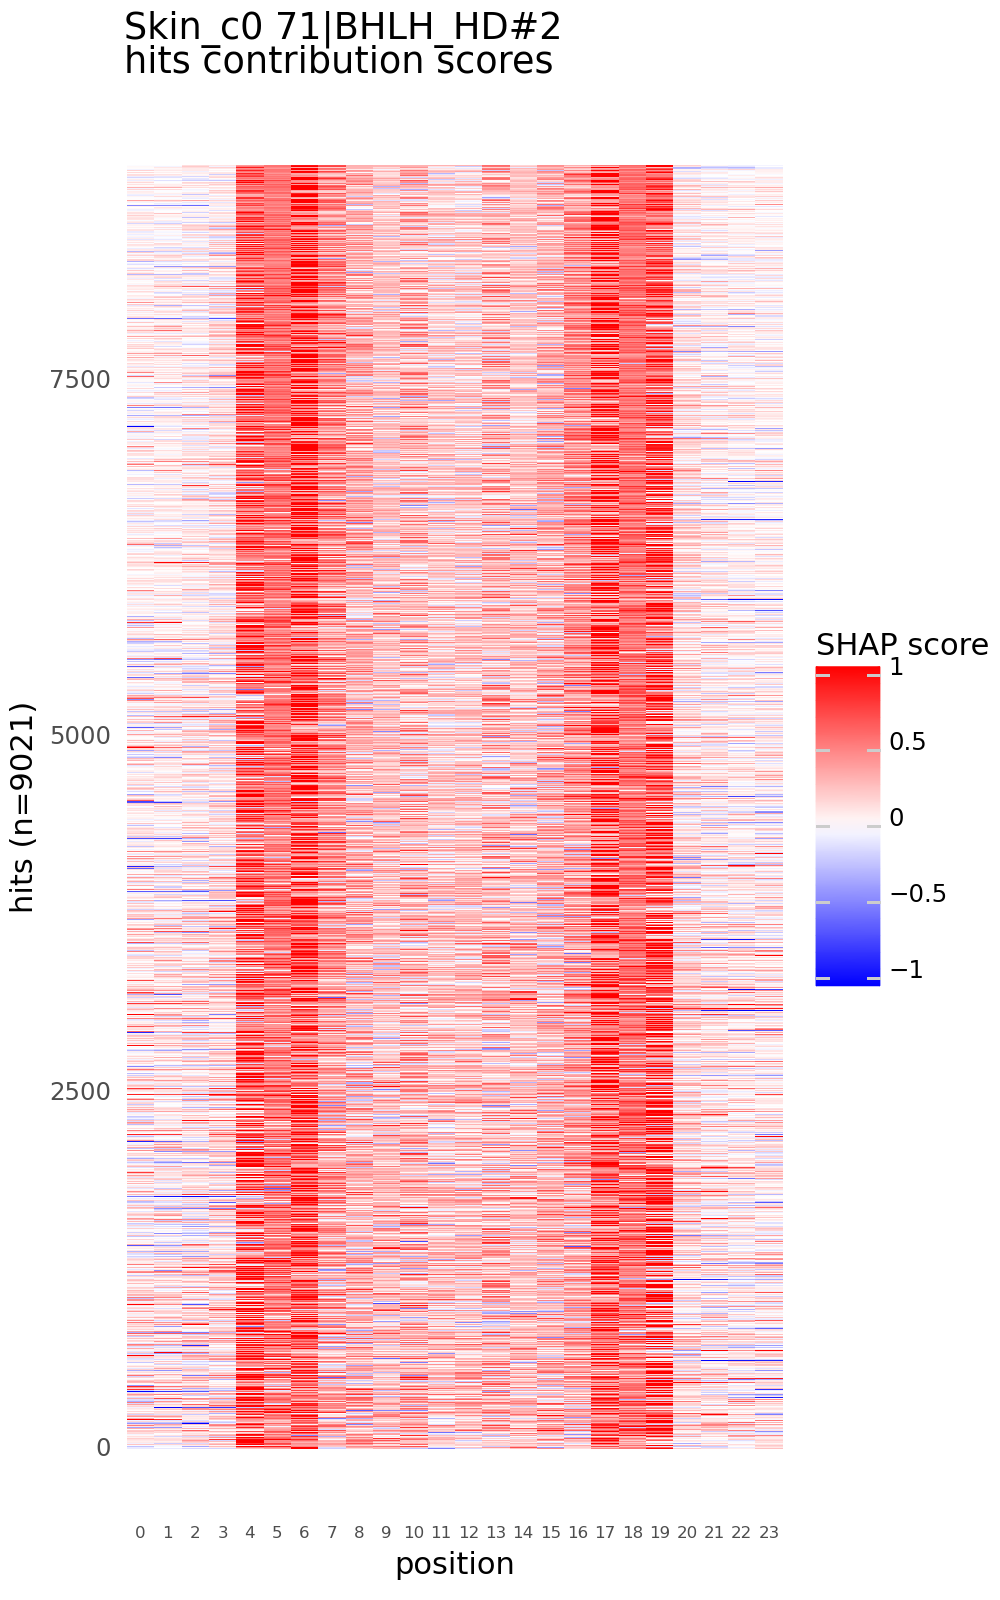

<Figure Size: (500 x 800)>

In [38]:
# order hits
hit_order = hits_df.sort_values(by='hit_correlation').index

# trimmed CWM
cutils.plot.plot_logo(cwm[imp_start:imp_end].T)
plt.savefig(f"{out_prefix}_cwm.pdf", dpi=150);

# nuc composition heatmap
p1 = cutils.plot.hit_heatmap2(ohe, pattern_name=f"{cluster} {motif}", figsize=(5,8), hit_order = hit_order)
p1.save(filename=f"{out_prefix}_nuc_composition.pdf", width=5, height=8, units='in', dpi=1000, verbose=False);
p1;

# contribs heatmap
p2 = cutils.plot.hit_contrib_heatmap(contribs, pattern_name=f"{cluster} {motif}", figsize=(5,8), hit_order = hit_order, normalize=True);
p2.save(filename=f"{out_prefix}_contrib_scores.pdf", width=5, height=8, units='in', dpi=1000, verbose=False);
p2

## BCL11A reducing pattern in spleen

In [59]:
cluster = "Spleen_c10"
motif = "4|BCL11A/Brepressive"
motif_info = get_motifs_compiled(motif_name = motif)
pattern = motif_info["pattern"].values[0]
idx = motif_info["idx_uniq"].values[0]
out_prefix = os.path.join(figout, f"{cluster}_{idx}")

In [60]:
cwm, imp_start, imp_end, hits_df, ohe, contribs = cutils.modisco.extract_hit_data(
    modisco_obj = modisco_obj,
    contribs_bw = f"{contribs_dir}/{cluster}/average_shaps.counts.bw",
    conservation_bw = phylop_path,
    hits = f"{hits_dir}/{cluster}/{finemo_param}/hits_unique.reconciled.annotated.tsv.gz",
    genome = genome,
    pattern_name = pattern,
    pattern_class = "neg_patterns",
    motif_name = motif,
    revcomp_strand = "-")

@ returning hits trimmed to width 14
@ returning 10128 hits
@ reverse complementing hit one-hot-encodings and SHAPs


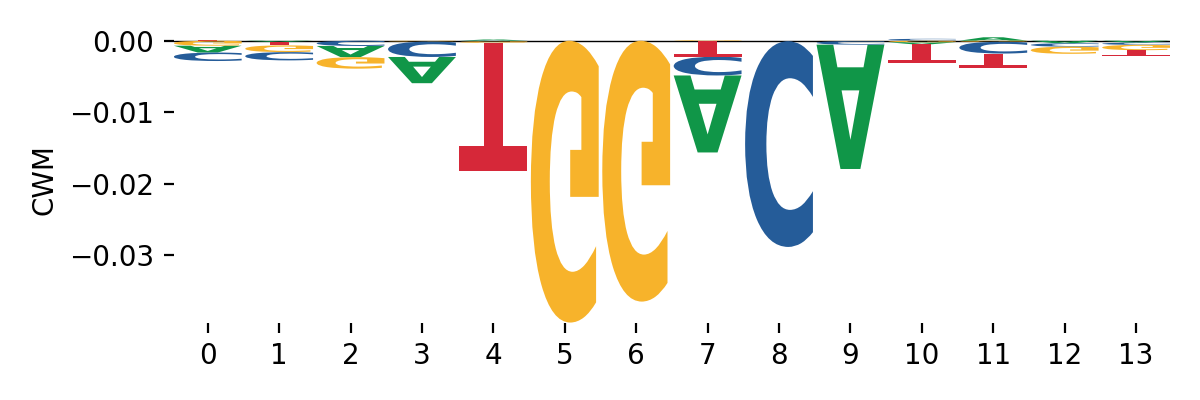

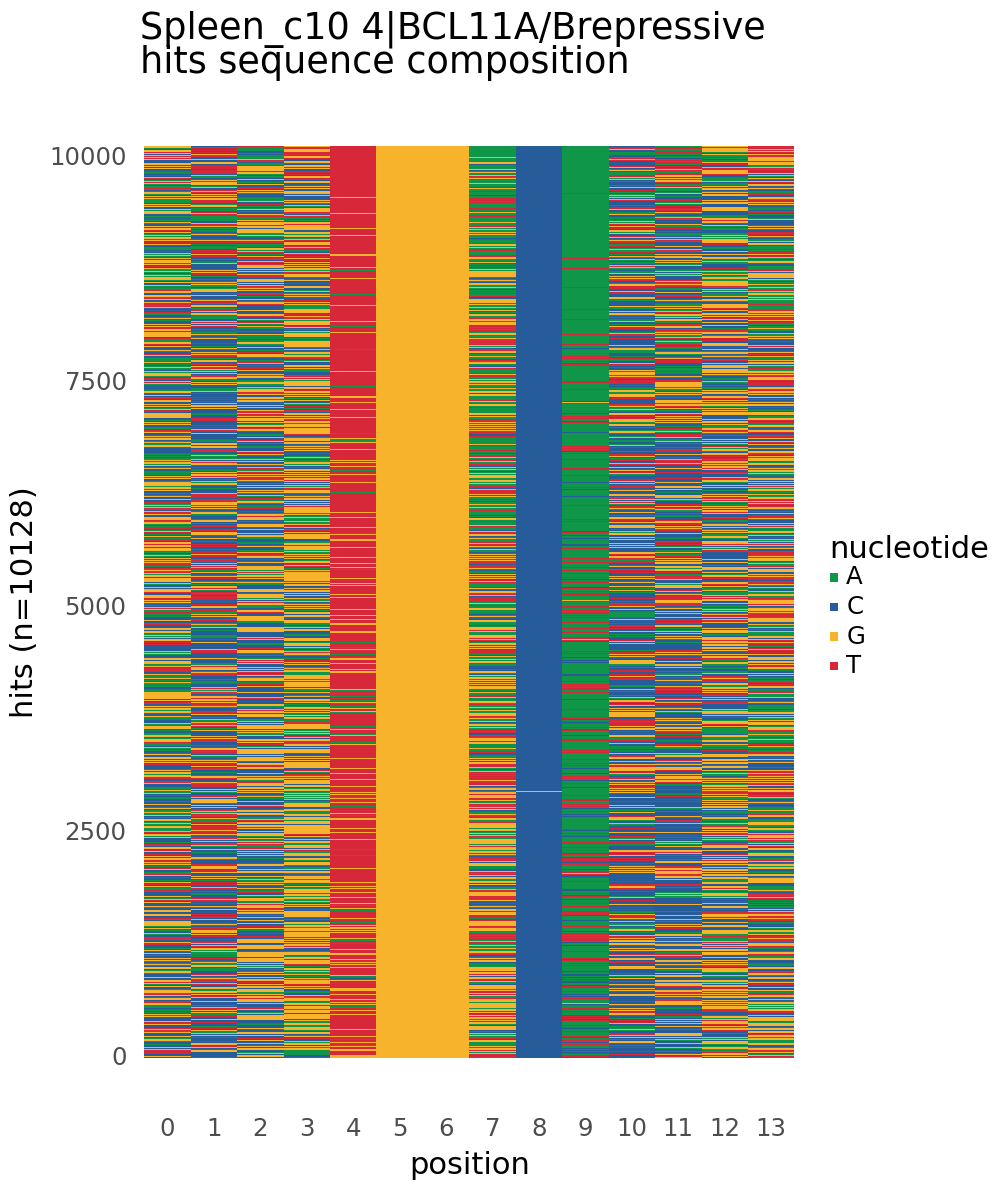

<Figure Size: (500 x 600)>

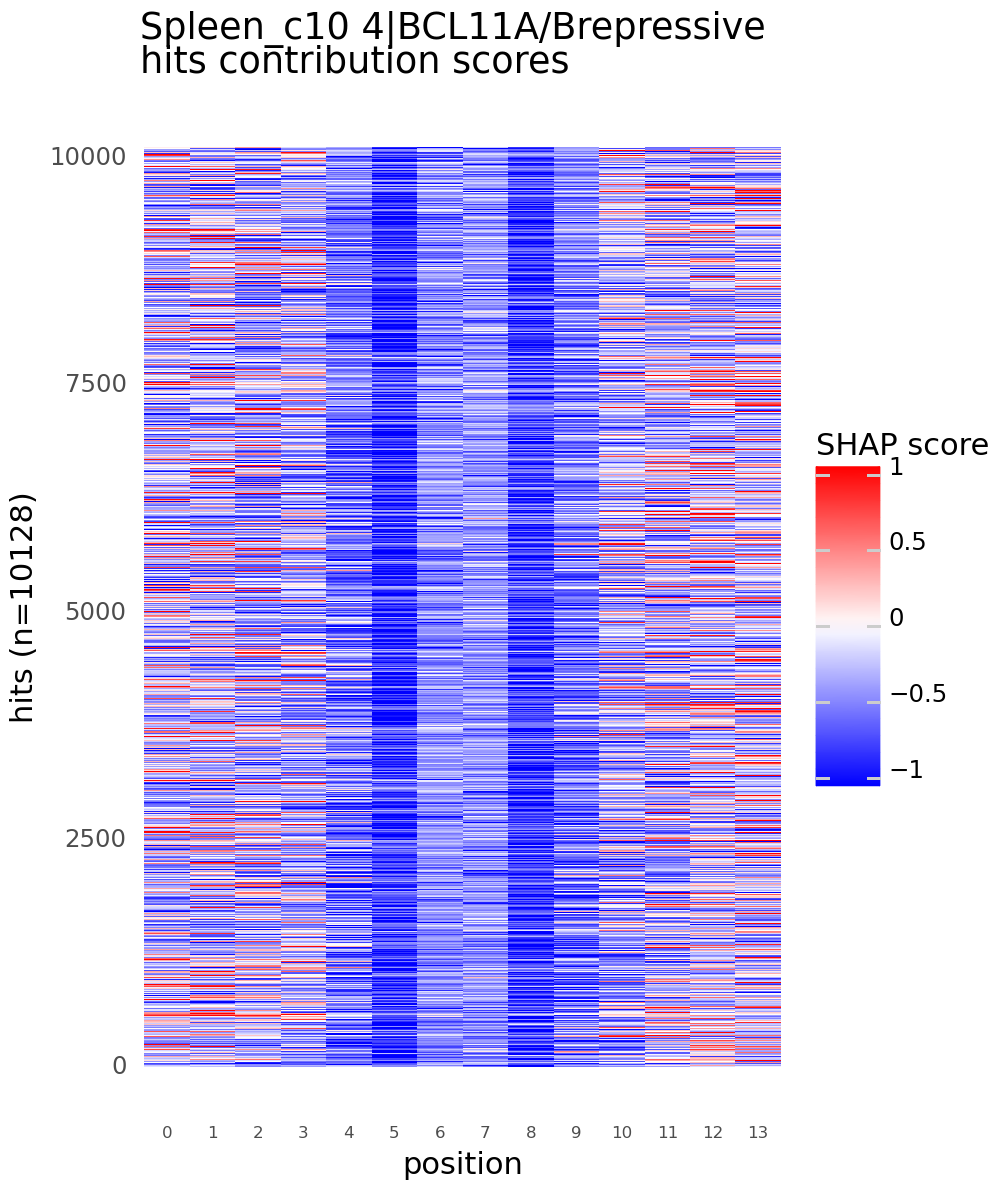

<Figure Size: (500 x 600)>

In [48]:
# order hits
hit_order = hits_df.sort_values(by='hit_correlation').index

# trimmed CWM
cutils.plot.plot_logo(cwm[imp_start:imp_end].T)
plt.savefig(f"{out_prefix}_cwm.pdf", dpi=150);

# nuc composition heatmap
p1 = cutils.plot.hit_heatmap2(ohe, pattern_name=f"{cluster} {motif}", figsize=(5,6), hit_order = hit_order)
p1.save(filename=f"{out_prefix}_nuc_composition.pdf", width=5, height=8, units='in', dpi=1000, verbose=False);
p1;

# contribs heatmap
p2 = cutils.plot.hit_contrib_heatmap(contribs, pattern_name=f"{cluster} {motif}", figsize=(5,6), hit_order = hit_order, normalize=True);
p2.save(filename=f"{out_prefix}_contrib_scores.pdf", width=5, height=8, units='in', dpi=1000, verbose=False);
p2

## An unresolved palindromic motif

In [62]:
motif = "503|unresolved,palindromic#1"
hit_counts.loc[hit_counts["motif_name"] == motif].sort_values(by=['n']).tail()

cluster = "Stomach_c1"
motif_info = get_motifs_compiled(motif_name = motif)
pattern = motif_info["pattern"].values[0]
idx = motif_info["idx_uniq"].values[0]
out_prefix = os.path.join(figout, f"{cluster}_{idx}")

,Cluster,motif_name,pattern_class,n,Distal,Exonic,Intronic,Promoter,mean_distToTSS,median_distToTSS,...,median_ngene,median_nfrags,median_tss,median_frip,note,organ_color,compartment_color,pattern,annotation_broad,category
13364,Lung_c2,"503|unresolved,palindromic#1",pos_patterns,6666,2198.0,296.0,3786.0,386.0,22617.72,10904.0,...,1768.0,7937.0,10.895,0.439747,PECAM1,#f0643e,#7F3C8D,pos.Average_288__merged_pattern_7,unresolved,unresolved
11180,Lung_c0,"503|unresolved,palindromic#1",pos_patterns,6798,2213.0,309.0,3847.0,429.0,21918.10,10202.5,...,1385.0,7820.0,11.198,0.470843,SFTPB SFTPC marker,#f0643e,#11A579,pos.Average_288__merged_pattern_7,unresolved,unresolved
8798,Liver_c1,"503|unresolved,palindromic#1",pos_patterns,6966,2060.0,390.0,3999.0,517.0,17773.49,8061.5,...,1477.0,7801.0,12.255,0.535465,high AFP ALB APOB,#3b46a3,#11A579,pos.Average_288__merged_pattern_7,unresolved,unresolved
13650,Lung_c3,"503|unresolved,palindromic#1",pos_patterns,8988,2922.0,396.0,5157.0,513.0,22236.71,10476.0,...,2488.0,10875.0,10.716,0.444721,DNAH11 DNAH5 dynein markers,#f0643e,#11A579,pos.Average_288__merged_pattern_7,unresolved,unresolved
26386,Stomach_c1,"503|unresolved,palindromic#1",pos_patterns,9029,2858.0,373.0,5264.0,534.0,21991.66,10717.0,...,1205.0,3480.0,9.464,0.413793,ACTA2+ MYH11+,#208A42,#3969AC,pos.Average_288__merged_pattern_7,unresolved,unresolved


In [64]:
cwm, imp_start, imp_end, hits_df, ohe, contribs = cutils.modisco.extract_hit_data(
    modisco_obj = modisco_obj,
    contribs_bw = f"{contribs_dir}/{cluster}/average_shaps.counts.bw",
    conservation_bw = phylop_path,
    hits = f"{hits_dir}/{cluster}/{finemo_param}/hits_unique.reconciled.annotated.tsv.gz",
    genome = genome,
    pattern_name = pattern,
    motif_name = motif,
    revcomp_strand = "-")

@ returning hits trimmed to width 18
@ returning 9029 hits
@ reverse complementing hit one-hot-encodings and SHAPs


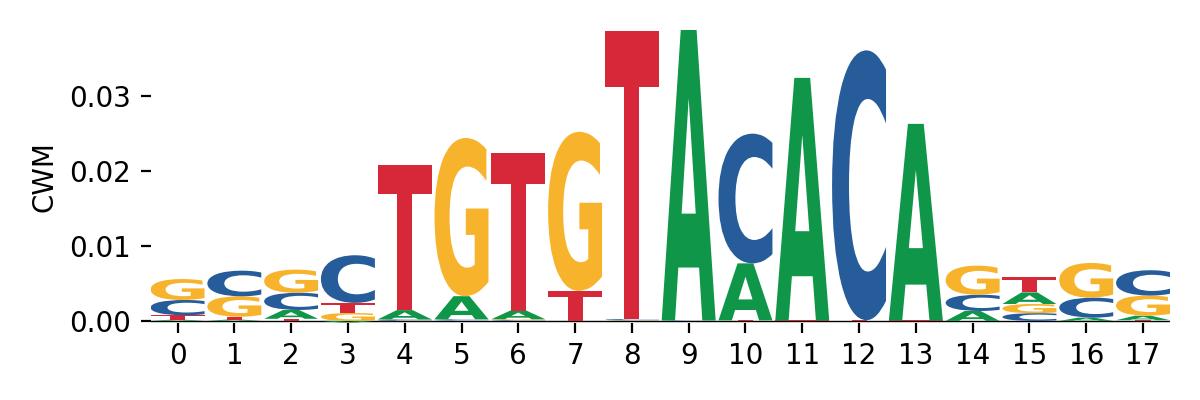

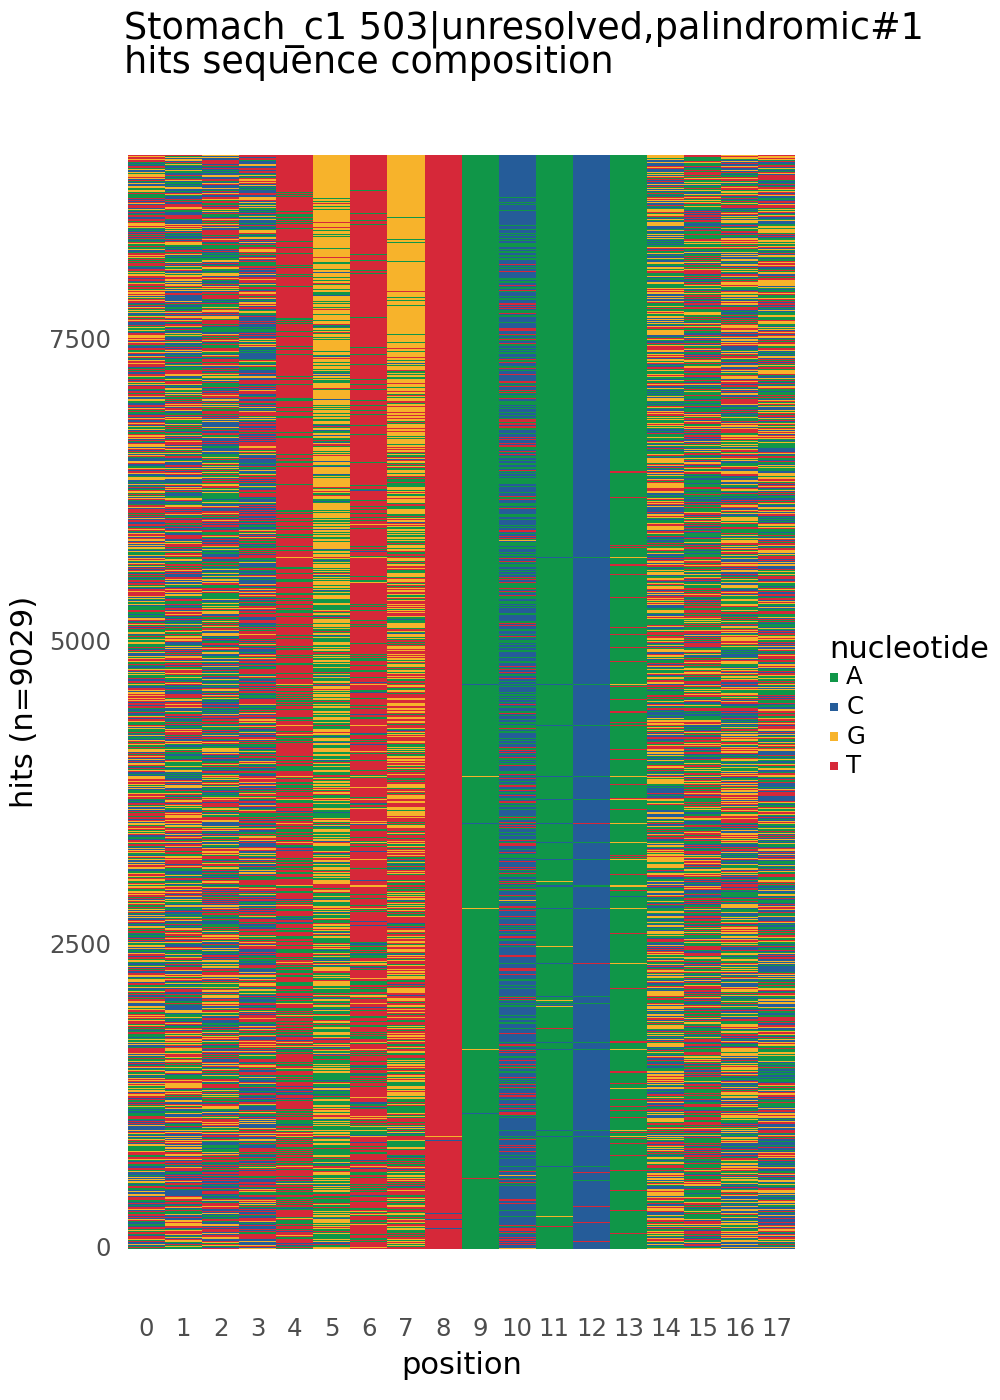

<Figure Size: (500 x 700)>

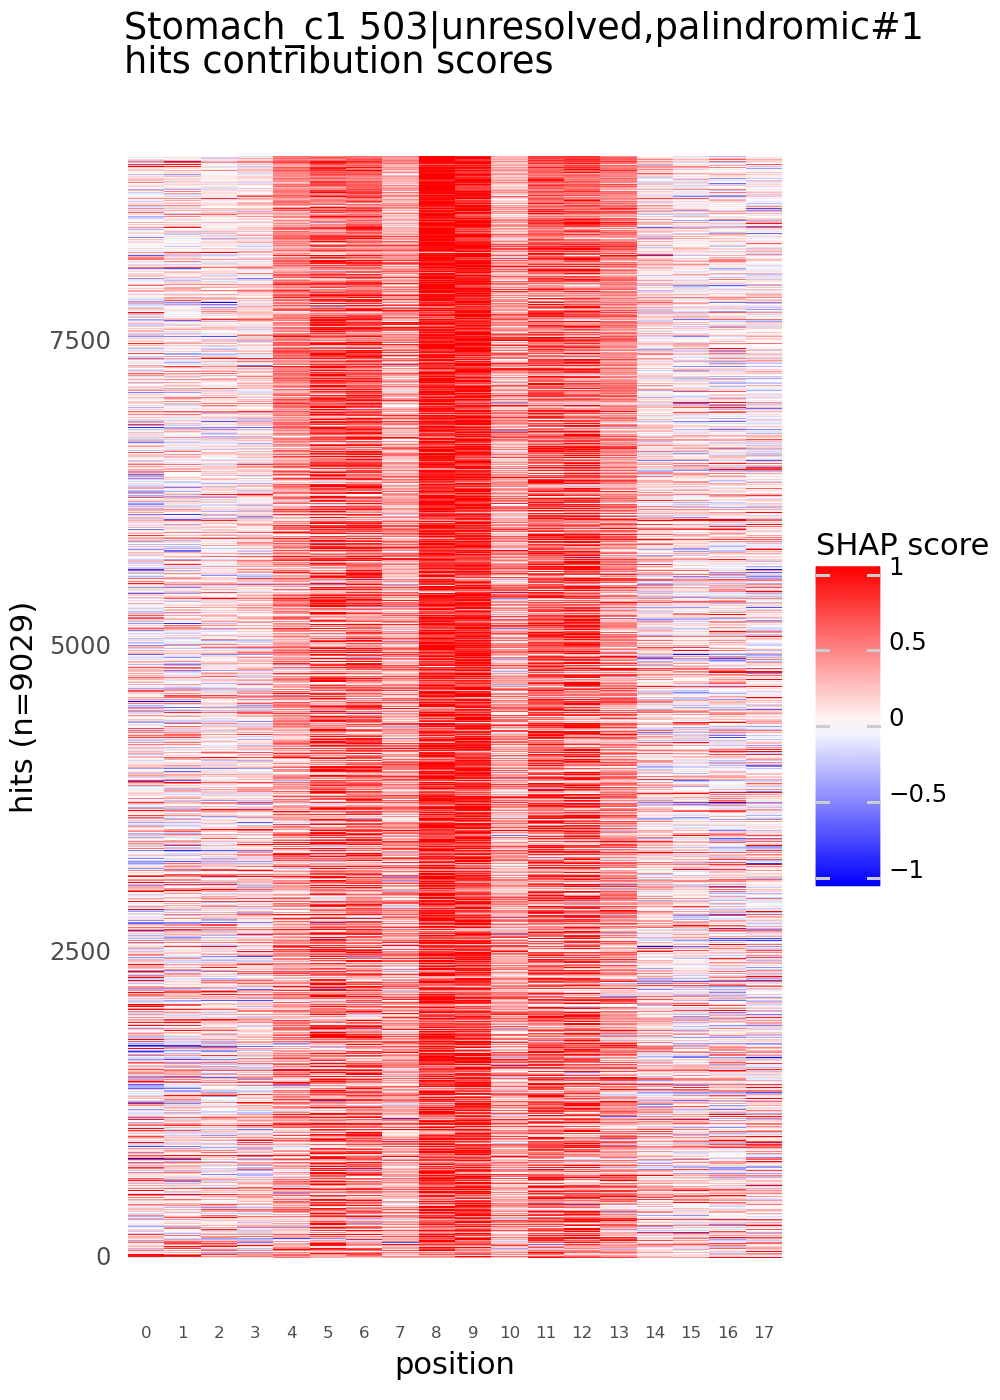

<Figure Size: (500 x 700)>

In [65]:
# order hits
hit_order = hits_df.sort_values(by='hit_correlation').index

# trimmed CWM
cutils.plot.plot_logo(cwm[imp_start:imp_end].T)
plt.savefig(f"{out_prefix}_cwm.pdf", dpi=150);

# nuc composition heatmap
p1 = cutils.plot.hit_heatmap2(ohe, pattern_name=f"{cluster} {motif}", figsize=(5,7), hit_order = hit_order)
p1.save(filename=f"{out_prefix}_nuc_composition.pdf", width=5, height=8, units='in', dpi=1000, verbose=False);
p1;

# contribs heatmap
p2 = cutils.plot.hit_contrib_heatmap(contribs, pattern_name=f"{cluster} {motif}", figsize=(5,7), hit_order = hit_order, normalize=True);
p2.save(filename=f"{out_prefix}_contrib_scores.pdf", width=5, height=8, units='in', dpi=1000, verbose=False);
p2